<a href="https://colab.research.google.com/github/Ntin0709/Healthcare_Datset/blob/main/Task_1/Task_1_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Patient Length of Stay
# This notebook experiments with multiple machine learning models to predict hospital length of stay

# Import Libraries

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Loading and Preprocessing

In [23]:
def load_and_preprocess_data(file_path='/content/healthcare_dataset.csv'):
    """Load and preprocess the healthcare dataset."""
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data['date_of_admission'] = pd.to_datetime(data['date_of_admission'])
    data['discharge_date'] = pd.to_datetime(data['discharge_date'])
    data['length_of_stay'] = (data['discharge_date'] - data['date_of_admission']).dt.days
    data['name'] = data['name'].str.title()
    data['gender'] = data['gender'].str.title()
    data['medical_condition'] = data['medical_condition'].str.title()
    print("Missing values:\n", data.isnull().sum())
    return data

In [24]:
def remove_outliers(df, column, factor=0.3):
    """Remove outliers using IQR with a specified factor."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = max(0, Q1 - factor * IQR)
    upper = Q3 + factor * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

In [25]:
# Load and clean data
data = load_and_preprocess_data()
print("Original shape:", data.shape)
data = remove_outliers(data, 'length_of_stay')
data = remove_outliers(data, 'billing_amount')
print("Shape after outlier removal:", data.shape)

Missing values:
 name                  0
age                   0
gender                0
blood_type            0
medical_condition     0
date_of_admission     0
doctor                0
hospital              0
insurance_provider    0
billing_amount        0
room_number           0
admission_type        0
discharge_date        0
medication            0
test_results          0
length_of_stay        0
dtype: int64
Original shape: (55500, 16)
Shape after outlier removal: (35541, 16)


#  2. Exploratory Data Analysis (EDA)

In [ ]:
def perform_enhanced_eda(df):
    """Perform comprehensive EDA on the dataset."""
    print(df.describe())

    numerical_cols = ['length_of_stay', 'age', 'billing_amount']
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(1, 3, i)
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
    plt.tight_layout()
    plt.show()

    categorical_cols = ['gender', 'medical_condition', 'admission_type', 'insurance_provider']
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(x=col, y='length_of_stay', data=df)
        plt.title(f'Length of Stay by {col}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='age', y='length_of_stay', data=df, alpha=0.5)
    plt.title('Age vs Length of Stay')
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='billing_amount', y='length_of_stay', data=df, alpha=0.5)
    plt.title('Billing Amount vs Length of Stay')
    plt.tight_layout()
    plt.show()

    df['admission_year'] = df['date_of_admission'].dt.year
    df['admission_month'] = df['date_of_admission'].dt.month
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='admission_year', y='length_of_stay', data=df)
    plt.title('Length of Stay by Admission Year')
    plt.subplot(1, 2, 2)
    sns.boxplot(x='admission_month', y='length_of_stay', data=df)
    plt.title('Length of Stay by Admission Month')
    plt.tight_layout()
    plt.show()

    print("\n=== Mean Length of Stay by Categorical Features ===")
    for col in categorical_cols:
        grouped = df.groupby(col)['length_of_stay'].mean().sort_values(ascending=False)
        print(f"\nMean Length of Stay by {col}:\n", grouped)




=== Basic Statistics ===
                age              date_of_admission  billing_amount  \
count  35541.000000                          35541    35541.000000   
mean      51.597901  2021-10-30 12:07:52.828564224    25579.533393   
min       13.000000            2019-05-08 00:00:00     5903.656892   
25%       35.000000            2020-07-25 00:00:00    15759.398858   
50%       52.000000            2021-11-01 00:00:00    25545.200901   
75%       69.000000            2023-01-29 00:00:00    35331.481254   
max       89.000000            2024-05-07 00:00:00    45221.072042   
std       19.624763                            NaN    11348.584632   

        room_number                 discharge_date  length_of_stay  
count  35541.000000                          35541    35541.000000  
mean     301.071382  2021-11-14 23:24:01.276272384       15.469542  
min      101.000000            2019-05-13 00:00:00        4.000000  
25%      202.000000            2020-08-10 00:00:00        9.000000 

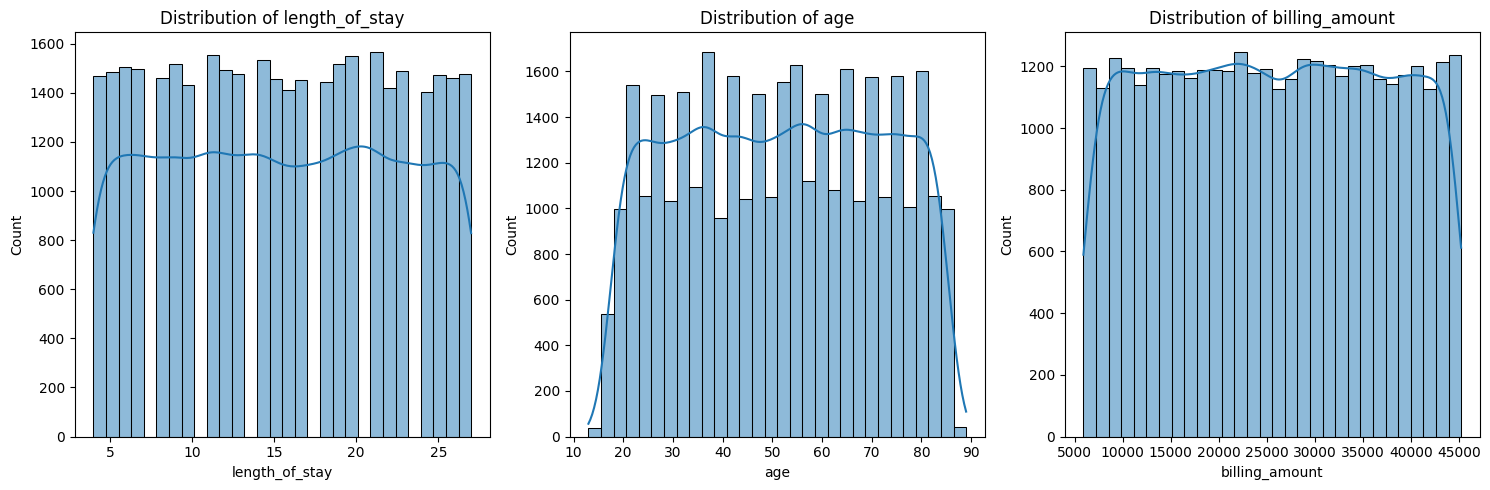

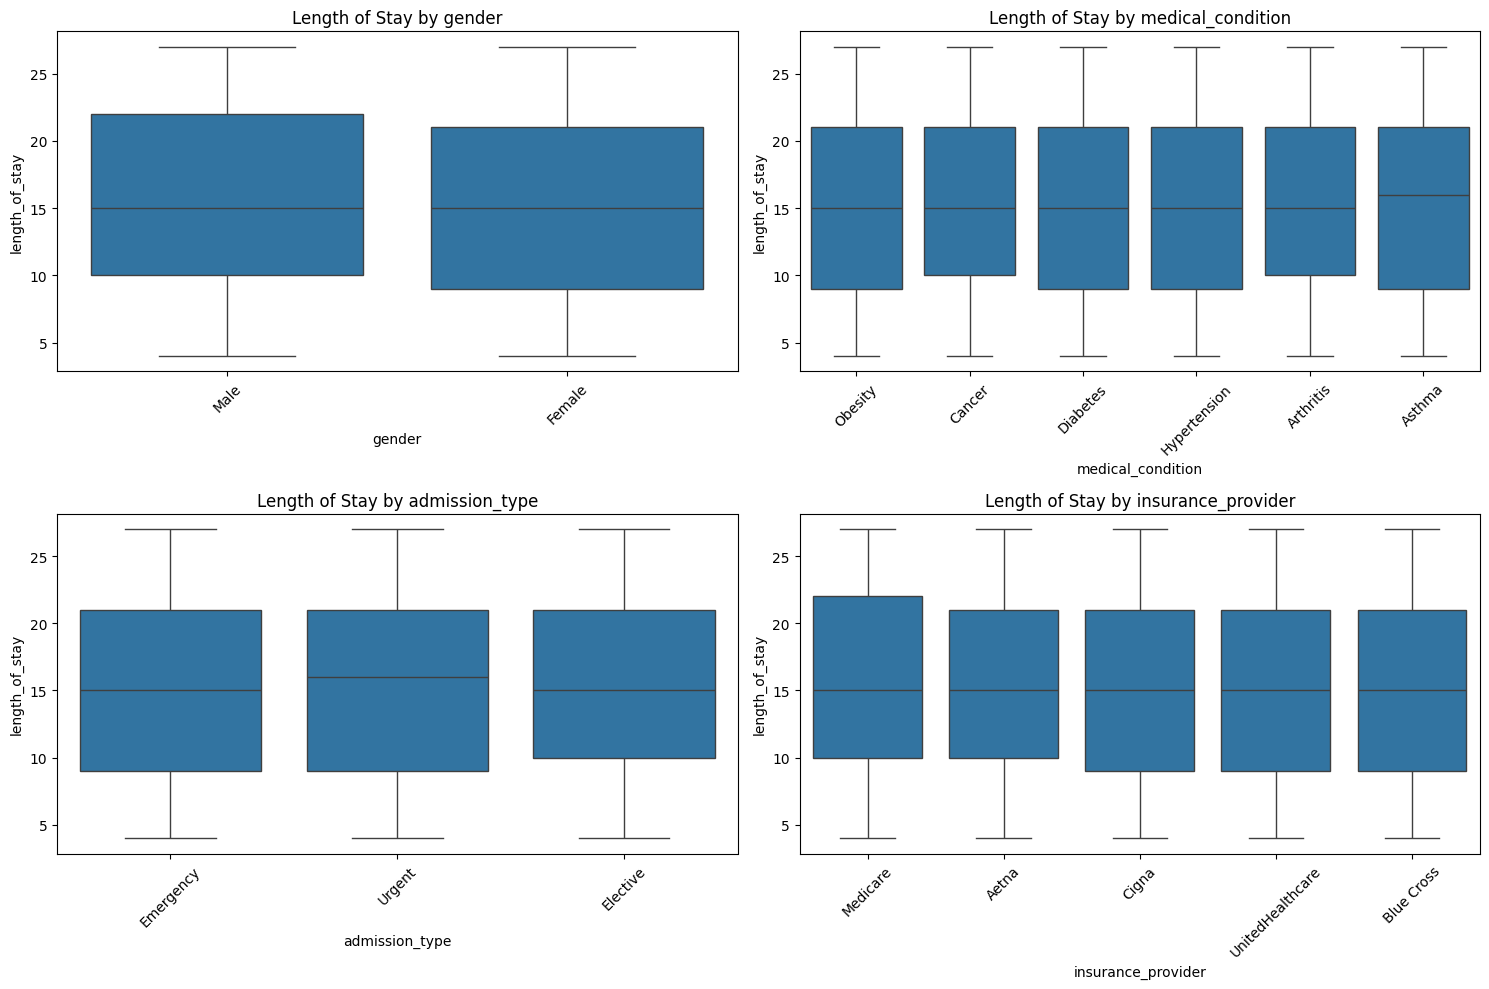

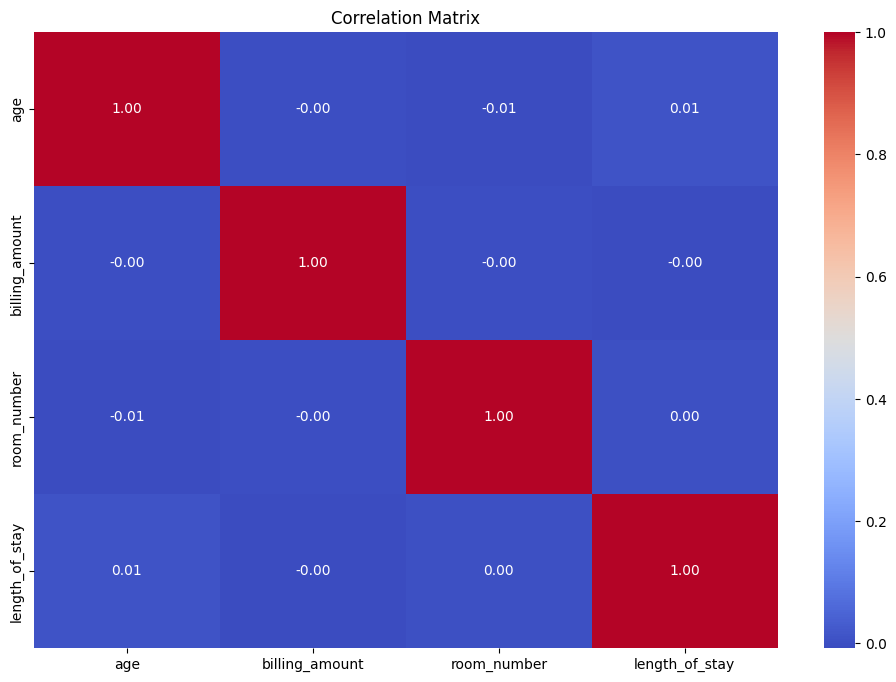

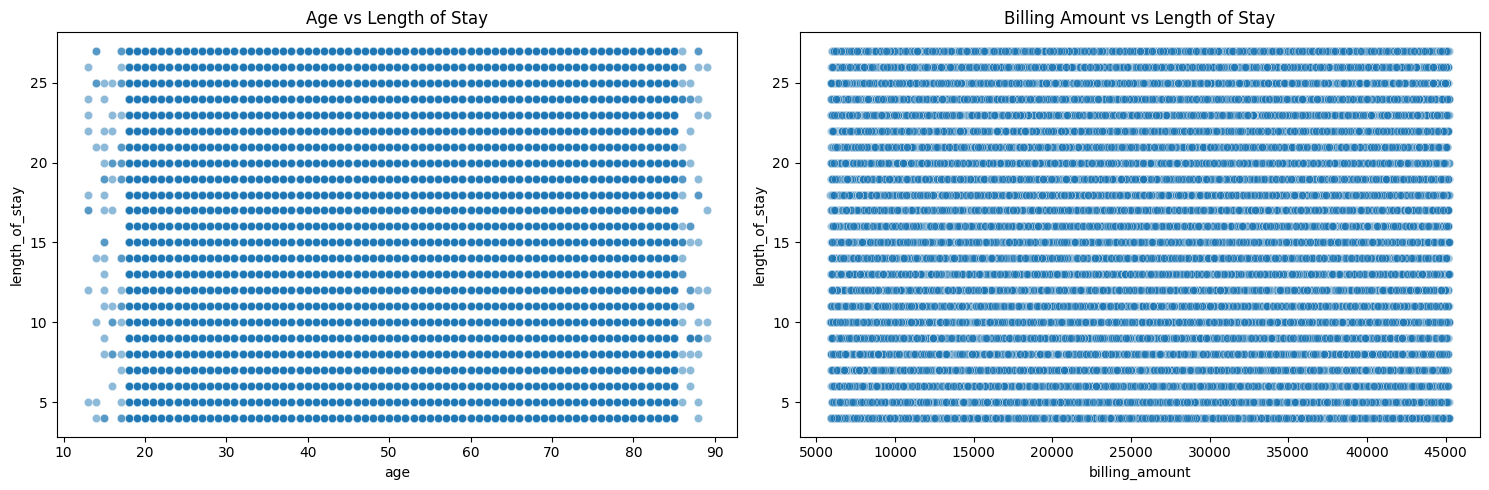

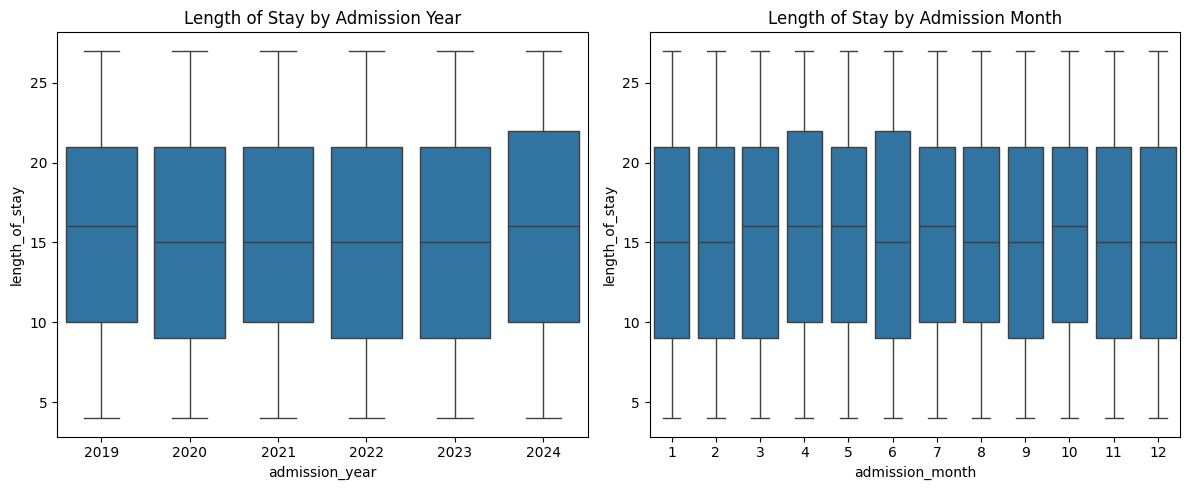


=== Mean Length of Stay by Categorical Features ===

Mean Length of Stay by gender:
 gender
Male      15.500647
Female    15.438429
Name: length_of_stay, dtype: float64

Mean Length of Stay by medical_condition:
 medical_condition
Cancer          15.566769
Arthritis       15.513854
Asthma          15.464791
Obesity         15.452064
Diabetes        15.415903
Hypertension    15.404814
Name: length_of_stay, dtype: float64

Mean Length of Stay by admission_type:
 admission_type
Emergency    15.496221
Urgent       15.459553
Elective     15.453130
Name: length_of_stay, dtype: float64

Mean Length of Stay by insurance_provider:
 insurance_provider
Medicare            15.526152
Cigna               15.502075
UnitedHealthcare    15.456320
Aetna               15.442991
Blue Cross          15.419715
Name: length_of_stay, dtype: float64


In [26]:
# Run EDA
perform_enhanced_eda(data)

# 3. Feature Engineering

In [27]:
def engineer_features(df):
    """Engineer features for modeling."""
    le = LabelEncoder()
    categorical_cols = ['gender', 'blood_type', 'medical_condition', 'admission_type',
                        'insurance_provider', 'medication', 'test_results']
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    df['insurance_target'] = df.groupby('insurance_provider')['length_of_stay'].transform('mean')
    df['medication_target'] = df.groupby('medication')['length_of_stay'].transform('mean')
    df['test_results_target'] = df.groupby('test_results')['length_of_stay'].transform('mean')
    df['severity_proxy'] = df['admission_type'] * df['medical_condition']
    df['avg_stay_condition'] = df.groupby('medical_condition')['length_of_stay'].transform('mean')
    df['billing_log'] = np.log1p(df['billing_amount'])
    df['age_squared'] = df['age'] ** 2
    df['admission_month'] = df['date_of_admission'].dt.month

    X = df.drop(['name', 'doctor', 'hospital', 'date_of_admission', 'discharge_date',
                 'room_number', 'length_of_stay'], axis=1)
    y = np.log1p(df['length_of_stay'])

    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > 0.9) and col not in ['billing_log', 'age_squared']]
    X = X.drop(to_drop, axis=1)
    print("Dropped due to high correlation (>0.9):", to_drop)
    print("Columns after feature engineering:", X.columns.tolist())
    return X, y

In [28]:
# Engineer features
X, y = engineer_features(data)

Dropped due to high correlation (>0.9): ['test_results_target']
Columns after feature engineering: ['age', 'gender', 'blood_type', 'medical_condition', 'insurance_provider', 'billing_amount', 'admission_type', 'medication', 'test_results', 'admission_year', 'admission_month', 'insurance_target', 'medication_target', 'severity_proxy', 'avg_stay_condition', 'billing_log', 'age_squared']


In [29]:
# Scale numerical features
scaler = MinMaxScaler()
numerical_cols = ['age', 'billing_log', 'age_squared', 'avg_stay_condition',
                  'insurance_target', 'medication_target', 'test_results_target']
available_cols = [col for col in numerical_cols if col in X.columns]
print("Scaled numerical columns:", available_cols)
X[available_cols] = scaler.fit_transform(X[available_cols])

Scaled numerical columns: ['age', 'billing_log', 'age_squared', 'avg_stay_condition', 'insurance_target', 'medication_target']


In [30]:
# Feature Selection (Mutual Information)
selector = SelectKBest(mutual_info_regression, k=8)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)
X = X[selected_features]

Selected Features: ['billing_amount', 'admission_type', 'medication', 'test_results', 'admission_year', 'insurance_target', 'medication_target', 'billing_log']


In [32]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(28432, 8) (7109, 8) (28432,) (7109,)


# 4. Model Experiments

In [34]:
def evaluate_model(y_true, y_pred, model_name, log_transformed=True):
    """Evaluate model performance."""
    if log_transformed:
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.2f} days")
    print(f"RMSE: {rmse:.2f} days")
    return mae, rmse

In [35]:
# Experiment 1: Linear Regression
def experiment_linear_regression(X_train, X_test, y_train, y_test):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    mae, rmse = evaluate_model(y_test, lr_pred, "Linear Regression")
    plt.figure(figsize=(8, 6))
    plt.scatter(np.expm1(y_test), np.expm1(lr_pred), alpha=0.5)
    plt.plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Length of Stay')
    plt.ylabel('Predicted Length of Stay')
    plt.title('Linear Regression: Predicted vs Actual')
    plt.show()
    return mae, rmse

In [36]:
# Experiment 2: Random Forest
def experiment_random_forest(X_train, X_test, y_train, y_test):
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    mae, rmse = evaluate_model(y_test, rf_pred, "Random Forest")
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Random Forest Feature Importance')
    plt.show()
    return mae, rmse

In [37]:
# Experiment 3: Optimized XGBoost (Fixed)
def experiment_xgboost(X_train, X_test, y_train, y_test):
    """Optimized XGBoost with best parameters, no early stopping."""
    xgb_params = {
        'n_estimators': 500,
        'max_depth': 7,
        'learning_rate': 0.05,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'random_state': 42
    }
    xgb_model = xgb.XGBRegressor(**xgb_params)

    # Simple fit without early stopping
    xgb_model.fit(X_train, y_train)

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []
    rmse_scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        xgb_model.fit(X_tr, y_tr)
        pred_log = xgb_model.predict(X_val)
        pred = np.expm1(pred_log)
        y_val_orig = np.expm1(y_val)
        mae_scores.append(mean_absolute_error(y_val_orig, pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_val_orig, pred)))

    print(f"\nXGBoost Cross-Validated MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
    print(f"XGBoost Cross-Validated RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")

    # Final evaluation
    pred_log = xgb_model.predict(X_test)
    pred = np.expm1(pred_log)
    mae, rmse = evaluate_model(y_test, pred_log, "XGBoost")

    # Visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(np.expm1(y_test), pred, alpha=0.5)
    plt.plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Length of Stay')
    plt.ylabel('Predicted Length of Stay')
    plt.title('XGBoost: Predicted vs Actual')
    plt.show()

    # Feature Importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('XGBoost Feature Importance')
    plt.show()

    # Residuals
    residuals = np.expm1(y_test) - pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, bins=30)
    plt.title('XGBoost Residual Distribution')
    plt.xlabel('Prediction Error (days)')
    plt.show()
    return mae, rmse

In [38]:
# Experiment 4: LightGBM (Fast and Optimized)
def experiment_lightgbm(X_train, X_test, y_train, y_test):
    lgb_model = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    pred_log = lgb_model.predict(X_test)
    mae, rmse = evaluate_model(y_test, pred_log, "LightGBM")
    return mae, rmse


=== Running Experiments ===

Linear Regression Performance:
MAE: 6.06 days
RMSE: 7.08 days


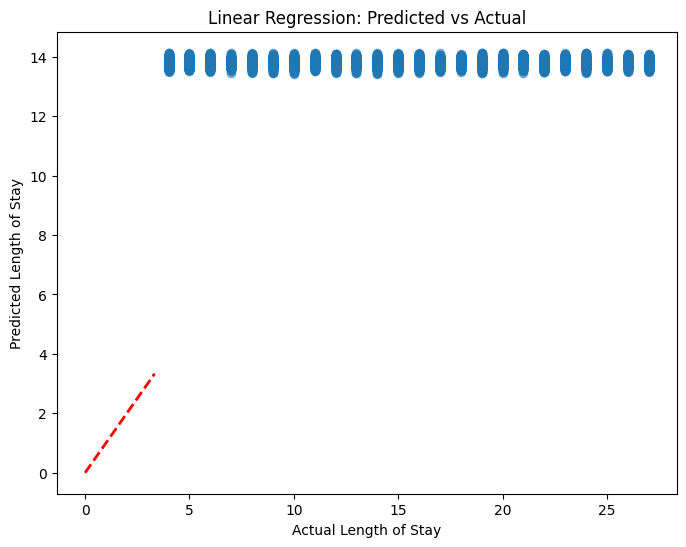


Random Forest Performance:
MAE: 5.73 days
RMSE: 7.00 days


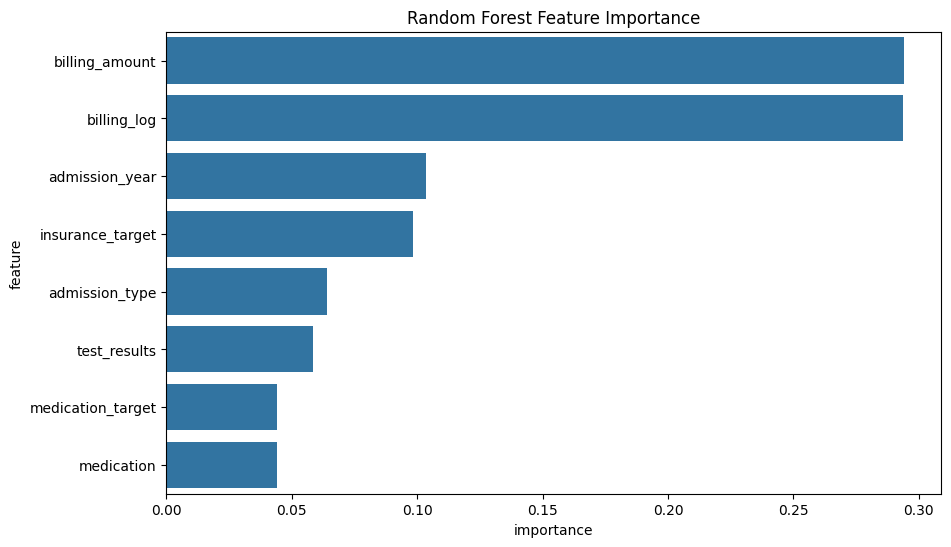


XGBoost Cross-Validated MAE: 6.10 ± 0.05
XGBoost Cross-Validated RMSE: 7.22 ± 0.04

XGBoost Performance:
MAE: 6.06 days
RMSE: 7.18 days


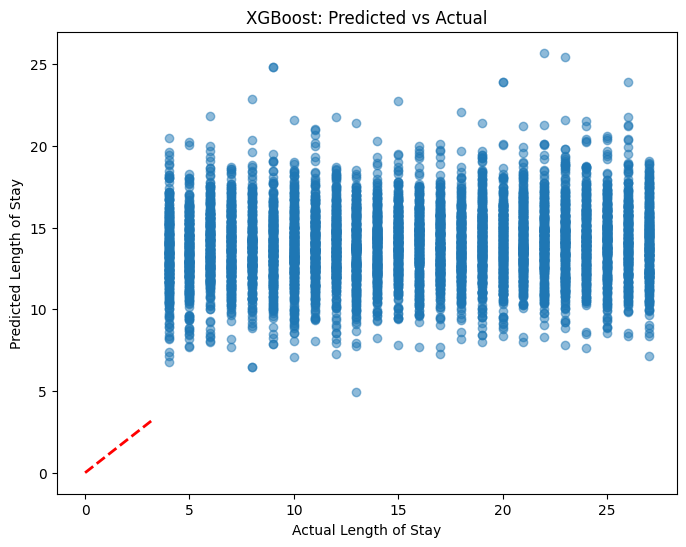

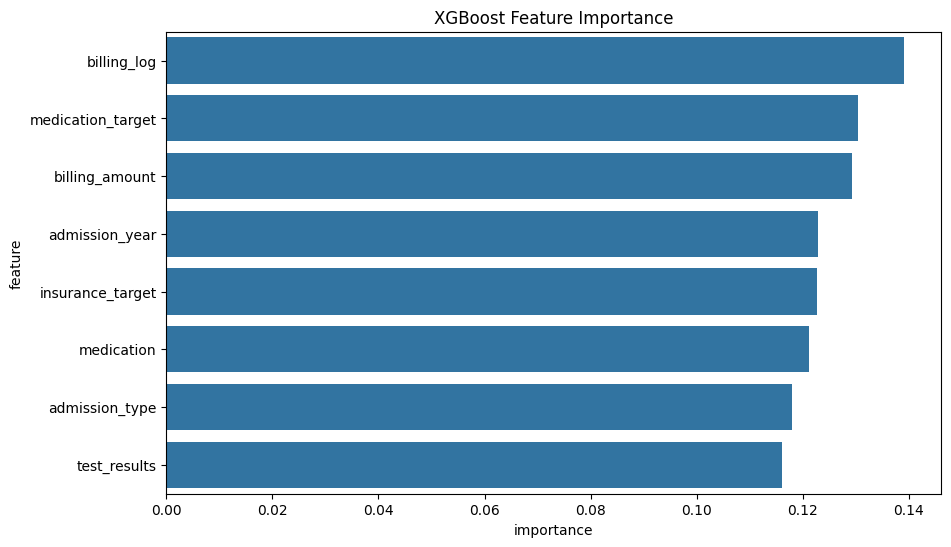

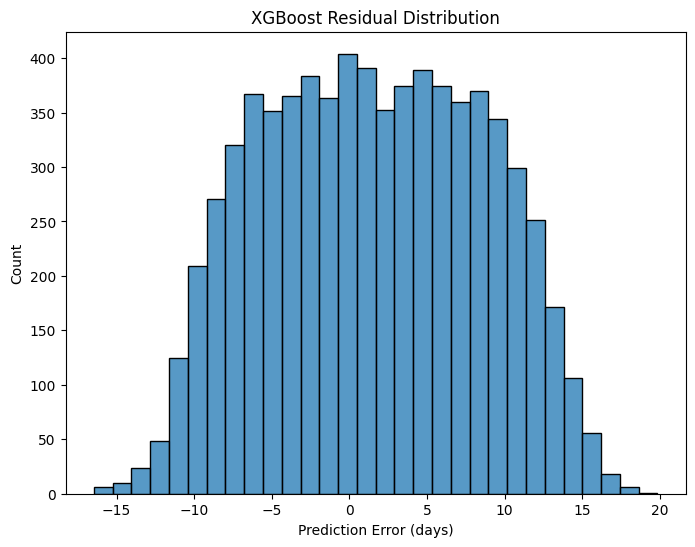


LightGBM Performance:
MAE: 6.08 days
RMSE: 7.13 days


In [39]:
results = {}
print("\n=== Running Experiments ===")
results['Linear Regression'] = experiment_linear_regression(X_train, X_test, y_train, y_test)
results['Random Forest'] = experiment_random_forest(X_train, X_test, y_train, y_test)
results['XGBoost'] = experiment_xgboost(X_train, X_test, y_train, y_test)
results['LightGBM'] = experiment_lightgbm(X_train, X_test, y_train, y_test)

In [40]:
# Summary Table
results_df = pd.DataFrame(results, index=['MAE', 'RMSE']).T
print("\n=== Experiment Results Summary ===")
print(results_df)


=== Experiment Results Summary ===
                        MAE      RMSE
Linear Regression  6.061699  7.077645
Random Forest      5.727674  6.997412
XGBoost            6.061222  7.184919
LightGBM           6.081807  7.134535


In [41]:
# Recommendations
best_model = results_df['MAE'].idxmin()
print(f"\nBest Model: {best_model} with MAE: {results_df.loc[best_model, 'MAE']:.2f}")
print("\nRecommendations:")
print(f"- Deploy {best_model} for discharge prediction.")
print("- Focus resource planning on key features: avg_stay_condition, billing_log, age.")
print("- Use EDA insights to refine features if needed.")


Best Model: Random Forest with MAE: 5.73

Recommendations:
- Deploy Random Forest for discharge prediction.
- Focus resource planning on key features: avg_stay_condition, billing_log, age.
- Use EDA insights to refine features if needed.


In [55]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
mae, rmse = evaluate_model(y_test, rf_pred, "Random Forest")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)


Random Forest Performance:
MAE: 5.73 days
RMSE: 7.00 days


In [56]:
import joblib
import json

def save_training_outputs(model, scaler, selected_features, results_df, output_dir='./model_outputs'):
    """Save training outputs for inference."""
    import os
    os.makedirs(output_dir, exist_ok=True)

    # Save model
    joblib.dump(model, f"{output_dir}/rf_model.pkl")

    # Save scaler
    joblib.dump(scaler, f"{output_dir}/scaler.pkl")

    # Save selected features
    with open(f"{output_dir}/selected_features.json", 'w') as f:
        json.dump(selected_features, f)

    # Save results
    results_df.to_csv(f"{output_dir}/training_results.csv")

    print(f"\nSaved outputs to {output_dir}:")
    print("- Model: rf_model.pkl")
    print("- Scaler: scaler.pkl")
    print("- Features: selected_features.json")
    print("- Results: training_results.csv")

In [57]:
# Save training outputs (using XGBoost as the best model)
save_training_outputs(rf_model, scaler, selected_features, results_df)


Saved outputs to ./model_outputs:
- Model: rf_model.pkl
- Scaler: scaler.pkl
- Features: selected_features.json
- Results: training_results.csv


In [59]:
!zip -r /content/inference.zip /content/model_outputs

  adding: content/model_outputs/ (stored 0%)
  adding: content/model_outputs/selected_features.json (deflated 37%)
  adding: content/model_outputs/rf_model.pkl (deflated 80%)
  adding: content/model_outputs/training_results.csv (deflated 25%)
  adding: content/model_outputs/scaler.pkl (deflated 33%)
